Частина N2

Список ідентифікаторів Landsat-8:<br>
    1. LC08_L1TP_182025_20190830_20190903_01_T1<br>
    2. LC08_L1TP_182026_20190830_20190903_01_T1<br>
Downloading data

In [2]:
import os
import subprocess
import glob
from glob import glob
from osgeo import gdal, osr
import rasterio
from rasterio.plot import show
import sklearn.metrics
import matplotlib.pyplot as plt
from pylandsat.download import Product
from tqdm import tqdm

print("Setup!")

y:\conda\envs\lab7_env_py312\Lib\site-packages\rasterio\path.py:15: RasterioDeprecationWarning: rasterio.path will be removed in version 1.4.
  warnings.warn(


Setup!


In [3]:
def download_data_landsat_8(directory, scene_ids):
      
    os.makedirs(directory, exist_ok=True)

    for scene_id in scene_ids:
        product = Product(scene_id)
        scene_dir = os.path.join(directory, scene_id)
        
        try:
            print(f"Завантаження знімка {scene_id}...")
            product.download(scene_dir, progressbar=True, verify=False)
        except Exception as e:
            print(f"Помилка завантаження знімка {scene_id}: {e}")
            continue
        else:
            if os.path.isdir(scene_dir):
                contents = os.listdir(scene_dir)
                required_files = [f"{scene_id}_B1.TIF", f"{scene_id}_MTL.txt"]
                if all(f in contents for f in required_files):
                    print(f"Знімок {scene_id} завантажено успішно.")
                else:
                    print(f"Помилка завантаження знімка {scene_id}: відсутні необхідні файли.")
            else:
                print(f"Помилка завантаження знімка {scene_id}: каталог не створено.")

In [4]:
directory = 'landsat_8'
scene_ids = [
    "LC08_L1TP_182025_20190830_20190903_01_T1",
    "LC08_L1TP_182026_20190830_20190903_01_T1"
]
download_data_landsat_8(directory, scene_ids)

Завантаження знімка LC08_L1TP_182025_20190830_20190903_01_T1...


LC08_L1TP_182025_20190830_20190903_01_T1_B1.TIF: : 65.0MB [00:06, 10.0MB/s]                          
LC08_L1TP_182025_20190830_20190903_01_T1_B2.TIF: : 67.1MB [00:06, 10.4MB/s]                          
LC08_L1TP_182025_20190830_20190903_01_T1_B3.TIF: : 71.3MB [00:06, 10.2MB/s]                          
LC08_L1TP_182025_20190830_20190903_01_T1_B4.TIF: : 76.5MB [00:07, 10.6MB/s]                          
LC08_L1TP_182025_20190830_20190903_01_T1_B5.TIF: : 90.2MB [00:08, 10.5MB/s]                          
LC08_L1TP_182025_20190830_20190903_01_T1_B6.TIF: : 89.1MB [00:08, 10.8MB/s]                          
LC08_L1TP_182025_20190830_20190903_01_T1_B7.TIF: : 86.0MB [00:08, 10.7MB/s]                          
LC08_L1TP_182025_20190830_20190903_01_T1_B8.TIF: : 285MB [00:25, 11.1MB/s]                          
LC08_L1TP_182025_20190830_20190903_01_T1_B9.TIF: : 45.1MB [00:04, 10.2MB/s]                          
LC08_L1TP_182025_20190830_20190903_01_T1_B10.TIF: : 66.1MB [00:06, 9.73MB/s]       

Помилка завантаження знімка LC08_L1TP_182025_20190830_20190903_01_T1: відсутні необхідні файли.
Завантаження знімка LC08_L1TP_182026_20190830_20190903_01_T1...


LC08_L1TP_182026_20190830_20190903_01_T1_B1.TIF: : 66.1MB [00:06, 9.88MB/s]                          
LC08_L1TP_182026_20190830_20190903_01_T1_B2.TIF: : 69.2MB [00:06, 10.5MB/s]                          
LC08_L1TP_182026_20190830_20190903_01_T1_B3.TIF: : 73.4MB [00:07, 10.3MB/s]                          
LC08_L1TP_182026_20190830_20190903_01_T1_B4.TIF: : 78.6MB [00:07, 10.7MB/s]                          
LC08_L1TP_182026_20190830_20190903_01_T1_B5.TIF: : 90.2MB [00:08, 10.6MB/s]                          
LC08_L1TP_182026_20190830_20190903_01_T1_B6.TIF: : 87.0MB [00:08, 10.7MB/s]                          
LC08_L1TP_182026_20190830_20190903_01_T1_B7.TIF: : 84.9MB [00:08, 10.5MB/s]                          
LC08_L1TP_182026_20190830_20190903_01_T1_B8.TIF: : 289MB [00:26, 11.1MB/s]                          
LC08_L1TP_182026_20190830_20190903_01_T1_B9.TIF: : 45.1MB [00:04, 10.1MB/s]                          
LC08_L1TP_182026_20190830_20190903_01_T1_B10.TIF: : 67.1MB [00:06, 10.3MB/s]       

Помилка завантаження знімка LC08_L1TP_182026_20190830_20190903_01_T1: відсутні необхідні файли.


Протестувати різні реалізовані в gdal методи паншарпенінгу. Для цього підготуйте склеєні RGB канали Landsat-8 та окремо панхроматичний
канал.



<i>Concatenate RGB</i>

In [ ]:
def concatenate_bands(input_dir, output_dir):
    bands = ['B2', 'B3', 'B4']  # Синій, зелений, червоний
    band_files = []

    # Створюємо директорію для вихідного файлу, якщо її не існує
    os.makedirs(output_dir, exist_ok=True)

    # Знаходимо файли каналів за шаблоном
    for band in bands:
        band_pattern = os.path.join(input_dir, f"*_{band}.TIF")
        band_path = glob(band_pattern)
        if not band_path:
            print(f"Файл каналу {band} не знайдено в директорії {input_dir}")
            return
        band_files.append(band_path[0])

    # Відкриваємо перший канал для отримання розміру та геоприв'язки
    src_ds = gdal.Open(band_files[0])
    if src_ds is None:
        print(f"Не вдалося відкрити файл {band_files[0]}")
        return

    driver = gdal.GetDriverByName('GTiff')
    output_file = os.path.join(output_dir, "concatenated_RGB.tif")

    # Створюємо вихідний файл із 3 каналами
    out_ds = driver.Create(
        output_file,
        src_ds.RasterXSize,
        src_ds.RasterYSize,
        len(band_files),
        src_ds.GetRasterBand(1).DataType
    )
    out_ds.SetGeoTransform(src_ds.GetGeoTransform())
    out_ds.SetProjection(src_ds.GetProjection())

    # Читаємо і записуємо кожен канал
    for idx, band_file in enumerate(band_files):
        in_ds = gdal.Open(band_file)
        if in_ds is None:
            print(f"Не вдалося відкрити файл {band_file}")
            out_ds = None
            return
        band_data = in_ds.GetRasterBand(1).ReadAsArray()
        out_band = out_ds.GetRasterBand(idx + 1)
        out_band.WriteArray(band_data)
        out_band.FlushCache()

    # Закриваємо файли
    out_ds = None
    print(f"Конкатенація каналів завершена. Результат записано у файл {output_file}")


In [52]:
img_data_25_path = os.path.join("landsat_8", 
                                "LC08_L1TP_182025_20190830_20190903_01_T1", 
                                "LC08_L1TP_182025_20190830_20190903_01_T1")
img_data_26_path = os.path.join("landsat_8", 
                                "LC08_L1TP_182026_20190830_20190903_01_T1", 
                                "LC08_L1TP_182026_20190830_20190903_01_T1")

concatenated_directory_25_RGB = "concat_LC08_25_RGB"
concatenated_directory_26_RGB = "concat_LC08_26_RGB"

print("Обробка LC08_L1TP_182025_20190830_20190903_01_T1")
print("Процес конкатинації....")
concatenate_bands(img_data_25_path, concatenated_directory_25_RGB)

print("Обробка LC08_L1TP_182026_20190830_20190903_01_T1")
print("Процес конкатинації....")
concatenate_bands(img_data_26_path, concatenated_directory_26_RGB)

Обробка LC08_L1TP_182025_20190830_20190903_01_T1
Процес конкатинації....
Конкатенація каналів завершена. Результат записано у файл concat_LC08_25_RGB\concatenated_RGB.tif
Обробка LC08_L1TP_182026_20190830_20190903_01_T1
Процес конкатинації....
Конкатенація каналів завершена. Результат записано у файл concat_LC08_26_RGB\concatenated_RGB.tif


SHOW with rasterio and plt

In [10]:
def open_and_display_tif(tif_file):
    try:
        # Відкриття файлу .tif за допомогою rasterio
        with rasterio.open(tif_file) as dataset:
            # Відображення зображення з вказаною колірною схемою            
            print(f"Displaying {tif_file}")
            fig, ax = plt.subplots(figsize=(10, 8))
            show(dataset, ax=ax, adjust=True)
              
            # Додаємо підпис до картинки
            ax.set_title(f"TIF Image: {tif_file}")
                
            plt.show()
            
    except Exception as e:
        print(f"An error occurred while opening the TIFF file: {e}")

LC08_L1TP_182025_20190830_20190903_01_T1

Displaying ./concat_LC08_25_RGB/concatenated_RGB.tif


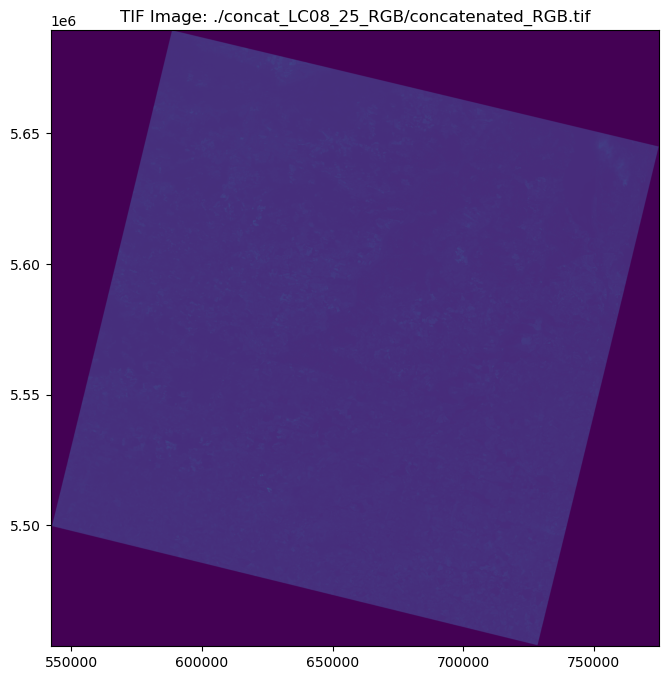

In [11]:
open_and_display_tif('./concat_LC08_25_RGB/concatenated_RGB.tif')  

LC08_L1TP_182026_20190830_20190903_01_T1

Displaying ./concat_LC08_26_RGB/concatenated_RGB.tif


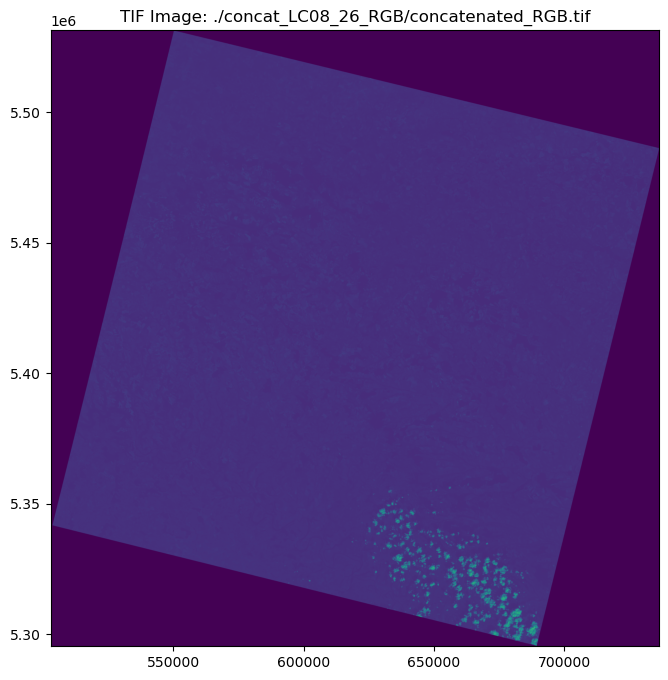

In [12]:
open_and_display_tif('./concat_LC08_26_RGB/concatenated_RGB.tif')  

<h4>Конкатенація каналів видимого, ближнього та середнього інфрачервоного спектральних діапазонів (канали 2, 3, 4 та 8) зображення в єдиний GEOTIFF файл.</h4> 

In [ ]:
def concatenate_bands_B8(input_dir, output_dir):
    bands = ['B2', 'B3', 'B4', 'B8']
    band_files = []

    os.makedirs(output_dir, exist_ok=True)

    # Знаходимо файли каналів
    for band in bands:
        band_pattern = os.path.join(input_dir, f"*_{band}.TIF")
        band_path = glob(band_pattern)
        if not band_path:
            print(f"❌ Файл каналу {band} не знайдено в директорії {input_dir}")
            return
        band_files.append(band_path[0])

    output_file = os.path.join(output_dir, "concatenated.tif")

    # Відкриваємо перший канал як еталон
    ref_ds = gdal.Open(band_files[0])
    ref_x = ref_ds.RasterXSize
    ref_y = ref_ds.RasterYSize
    ref_gt = ref_ds.GetGeoTransform()
    ref_proj = ref_ds.GetProjection()

    driver = gdal.GetDriverByName('GTiff')
    out_ds = driver.Create(output_file, ref_x, ref_y, len(band_files), ref_ds.GetRasterBand(1).DataType)
    out_ds.SetGeoTransform(ref_gt)
    out_ds.SetProjection(ref_proj)

    for idx, band_file in enumerate(band_files):
        in_ds = gdal.Open(band_file)
        if in_ds is None:
            print(f"❌ Не вдалося відкрити файл {band_file}")
            out_ds = None
            return
        
        # Читаємо дані з ресемплінгом до розміру референсу
        band_data = in_ds.GetRasterBand(1).ReadAsArray(
            buf_xsize=ref_x,
            buf_ysize=ref_y
        )

        out_band = out_ds.GetRasterBand(idx + 1)
        out_band.WriteArray(band_data)
        out_band.FlushCache()

        print(f"✅ Записано канал {bands[idx]}")

    out_ds = None
    print(f"🎉 Конкатенація каналів завершена. Результат: {output_file}")


In [22]:
img_data_25_path = os.path.join("landsat_8", 
                                "LC08_L1TP_182025_20190830_20190903_01_T1", 
                                "LC08_L1TP_182025_20190830_20190903_01_T1")
img_data_26_path = os.path.join("landsat_8", 
                                "LC08_L1TP_182026_20190830_20190903_01_T1", 
                                "LC08_L1TP_182026_20190830_20190903_01_T1")

concatenated_directory_25 = "concat_LC08_25"
concatenated_directory_26 = "concat_LC08_26"

print("Обробка LC08_L1TP_182025_20190830_20190903_01_T1")
print("Процес конкатинації....")
concatenate_bands_B8(img_data_25_path, concatenated_directory_25)

print("=" * 90)

print("Обробка LC08_L1TP_182026_20190830_20190903_01_T1")
print("Процес конкатинації....")
concatenate_bands_B8(img_data_26_path, concatenated_directory_26)

Обробка LC08_L1TP_182025_20190830_20190903_01_T1
Процес конкатинації....
✅ Записано канал B2
✅ Записано канал B3
✅ Записано канал B4
✅ Записано канал B8
🎉 Конкатенація каналів завершена. Результат: concat_LC08_25\concatenated.tif
Обробка LC08_L1TP_182026_20190830_20190903_01_T1
Процес конкатинації....
✅ Записано канал B2
✅ Записано канал B3
✅ Записано канал B4
✅ Записано канал B8
🎉 Конкатенація каналів завершена. Результат: concat_LC08_26\concatenated.tif


LC08_L1TP_182025_20190830_20190903_01_T1

Displaying ./concat_LC08_25/concatenated.tif


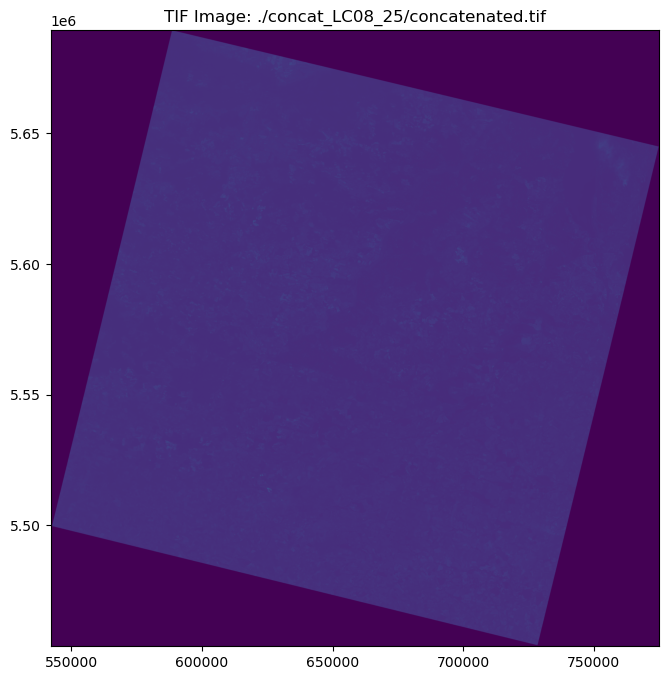

In [23]:
open_and_display_tif('./concat_LC08_25/concatenated.tif')  

LC08_L1TP_182026_20190830_20190903_01_T1

Displaying ./concat_LC08_26/concatenated.tif


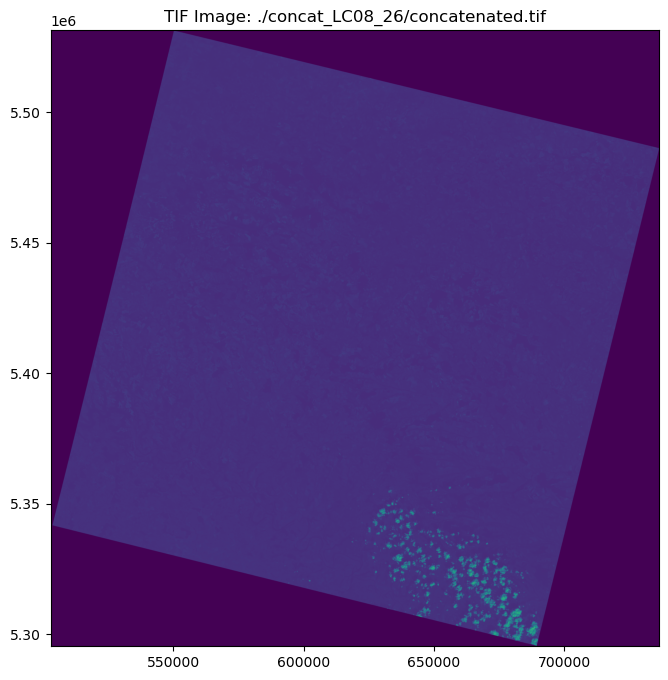

In [24]:
open_and_display_tif('./concat_LC08_26/concatenated.tif')  

<h4>Перепроектування супутникового зображення у проєкцію 4326.</h4>

In [28]:
def reproject_directory(input_dir, output_dir, target_epsg=4326):
    os.makedirs(output_dir, exist_ok=True)
    
    for filename in tqdm(os.listdir(input_dir), desc="Перепроектування файлів"):
        if filename.endswith((".tif", ".tiff")):
            reproject_to_target(
                os.path.join(input_dir, filename),
                os.path.join(output_dir, filename),
                target_epsg
            )

def reproject_to_target(input_raster, output_raster, target_epsg):
    try:
        src_ds = gdal.Open(input_raster)
        if src_ds is None:
            print(f"❌ Не вдалося відкрити {input_raster}")
            return

        src_proj = src_ds.GetProjectionRef()
        
        dst_srs = osr.SpatialReference()
        dst_srs.ImportFromEPSG(target_epsg)
        
        gdal.Warp(
            output_raster,
            src_ds,
            dstSRS=dst_srs
        )
        
        src_ds = None  # Закриваємо
        print(f"✅ Перепроектування {input_raster} завершено. Вихідний файл: {output_raster}")
    except Exception as e:
        print(f"❌ Помилка при перепроектуванні {input_raster}: {e}")


Show first part RGB from id LC08_L1TP_182025_20190830_20190903_01_T1....

In [29]:
input_dir = "./concat_LC08_25_RGB"
output_dir = "./reproject_LC08_25_RGB"  
reproject_directory(input_dir, output_dir)

Перепроектування файлів: 100%|██████████| 1/1 [00:05<00:00,  5.94s/it]

✅ Перепроектування ./concat_LC08_25_RGB\concatenated_RGB.tif завершено. Вихідний файл: ./reproject_LC08_25_RGB\concatenated_RGB.tif


Displaying ./reproject_LC08_25_RGB/concatenated_RGB.tif


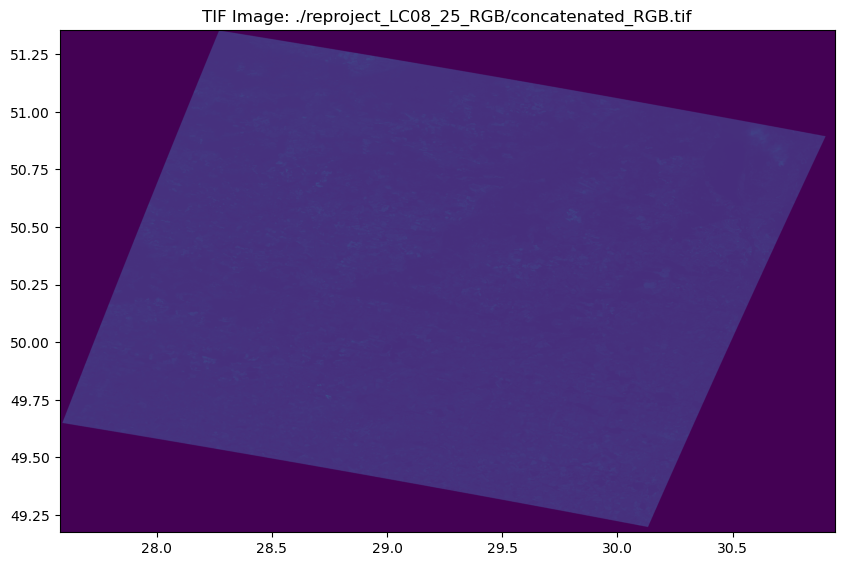

In [30]:
open_and_display_tif('./reproject_LC08_25_RGB/concatenated_RGB.tif')  

Show second part RGB from id LC08_L1TP_182026_20190830_20190903_01_T1....

In [31]:
input_dir = "./concat_LC08_26_RGB"
output_dir = "./reproject_LC08_26_RGB"  
reproject_directory(input_dir, output_dir)

Перепроектування файлів: 100%|██████████| 1/1 [00:05<00:00,  5.55s/it]

✅ Перепроектування ./concat_LC08_26_RGB\concatenated_RGB.tif завершено. Вихідний файл: ./reproject_LC08_26_RGB\concatenated_RGB.tif


Displaying ./reproject_LC08_26_RGB/concatenated_RGB.tif


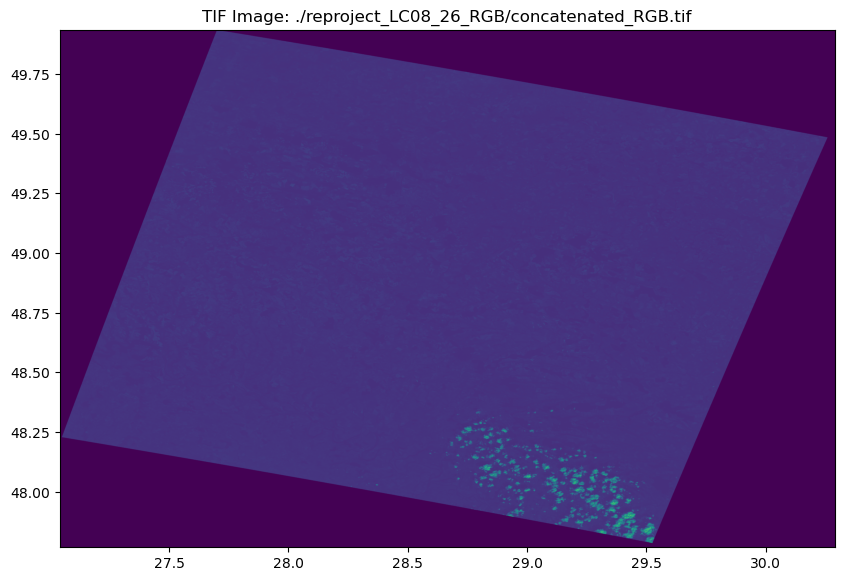

In [33]:
open_and_display_tif('./reproject_LC08_26_RGB/concatenated_RGB.tif')  

<h4>- Конкатенація всіх отриманих растрів у один 4-канальний файл TIFF. </h4>

In [45]:
from osgeo import gdal

def concatenate_all(directory_A, directory_B, output_file='output_4.tif'):
    tif_files = []
    for directory in [directory_A, directory_B]:
        for filename in os.listdir(directory):
            if filename.endswith('.tif'):
                tif_files.append(os.path.join(directory, filename))

    if not tif_files:
        print("No TIFF files found.")
        return

    vrt = gdal.BuildVRT('/vsimem/temp.vrt', tif_files)
    gdal.Translate(output_file, vrt)
    print(f"Concatenated file created: {output_file}")




RGB_CONCAT

In [46]:
directory_A = "./concat_LC08_25_RGB"
directory_B = "./concat_LC08_26_RGB"
output_file = "original_LC08_25_26_RGB.tif"
concatenate_all(directory_A, directory_B, output_file)

Concatenated file created: original_LC08_25_26_RGB.tif


Showing...

Displaying original_LC08_25_26_RGB.tif


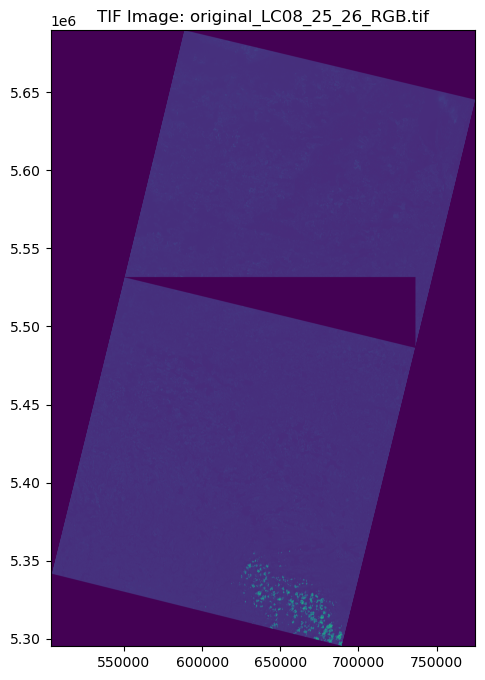

In [47]:
open_and_display_tif('original_LC08_25_26_RGB.tif')

REPROJ_RGB

In [48]:
directory_A = "./reproject_LC08_25_RGB"
directory_B = "./reproject_LC08_26_RGB"
output_file = "LC08_25_26_RGB.tif"
concatenate_all(directory_A, directory_B, output_file)

Concatenated file created: LC08_25_26_RGB.tif


Showing...

Displaying LC08_25_26_RGB.tif


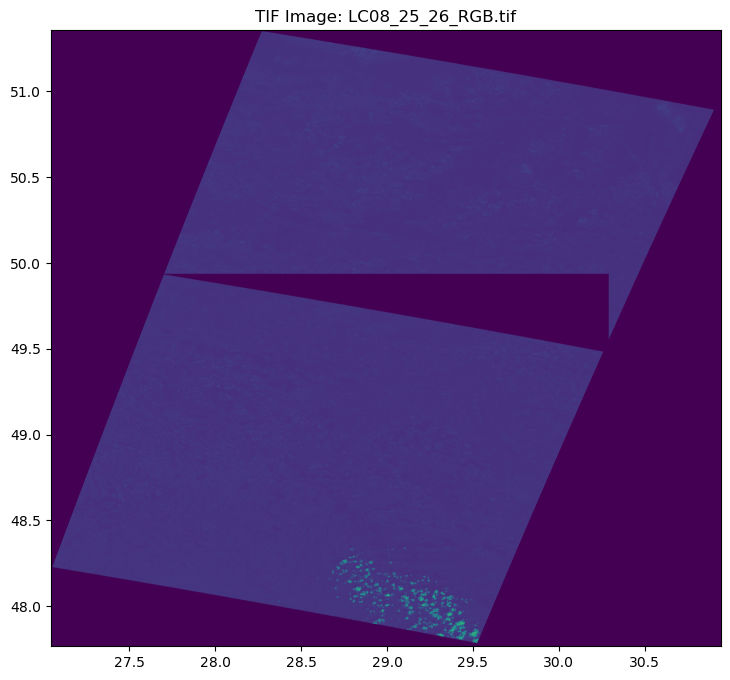

In [49]:
open_and_display_tif('LC08_25_26_RGB.tif')

4_CONCAT

In [50]:
directory_A = "./concat_LC08_25"
directory_B = "./concat_LC08_26"
output_file = "4_original_LC08_25_26.tif"
concatenate_all(directory_A, directory_B, output_file)

Concatenated file created: 4_original_LC08_25_26.tif


Showing...

Displaying 4_original_LC08_25_26.tif


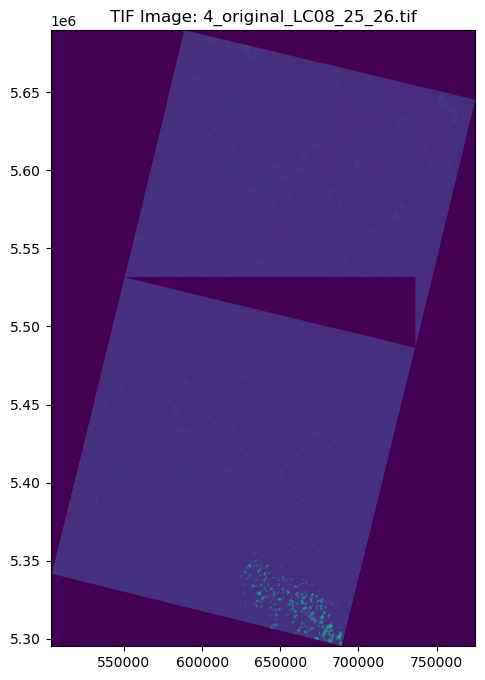

In [51]:
open_and_display_tif('4_original_LC08_25_26.tif')

Переведіть панхроматичний канал у 30 м, а RGB канали у 60 метрів.

In [64]:
def create_directory(directory_name):
    if not os.path.exists(directory_name):
        os.makedirs(directory_name)
        print(f"Directory '{directory_name}' created successfully.")
    else:
        print(f"Directory '{directory_name}' already exists.")

def gdal_translate(input_image, output_image, target_resolution):
    try:
        command = f"gdal_translate -tr {target_resolution} {target_resolution} {input_image} {output_image}"
        subprocess.run(command, shell=True, check=True)
        
        print("Image successfully translated using gdal_translate.")
    except subprocess.CalledProcessError as e:
        print(f"An error occurred while translating the image using gdal_translate: {e}")

gdal_translate (30 m)

In [ ]:
directory_name = "./LANDSAT_PANSHARPEN"
create_directory(directory_name)
gdal_translate("./landsat_8/LC08_L1TP_182025_20190830_20190903_01_T1/LC08_L1TP_182025_20190830_20190903_01_T1/LC08_L1TP_182025_20190830_20190903_01_T1_B8.TIF", os.path.join(directory_name, "RGB_PANSHARPEN_30_B8.tif"), target_resolution=30)

Directory './LANDSAT_PANSHARPEN' created successfully.
Image successfully translated using gdal_translate.


Show with rasterio and plt...

Displaying ./LANDSAT_PANSHARPEN/RGB_PANSHARPEN_30_B8.tif


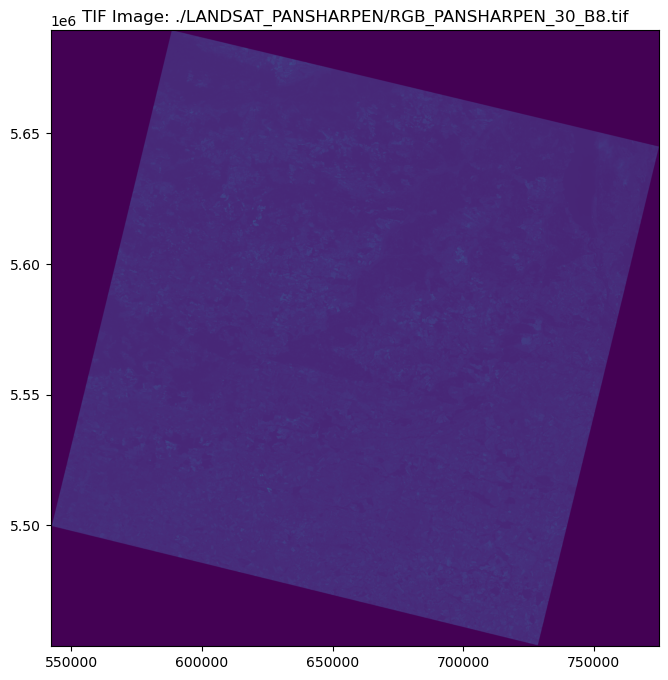

In [67]:
open_and_display_tif("./LANDSAT_PANSHARPEN/RGB_PANSHARPEN_30_B8.tif")

gdal_translate(60 m)

In [68]:
gdal_translate("./concat_LC08_25_RGB/concatenated_RGB.tif", os.path.join(directory_name, "RGB_PANSHARPEN_60.tif"), target_resolution=60)

Image successfully translated using gdal_translate.


Show with rasterio and plt...

Displaying ./LANDSAT_PANSHARPEN/RGB_PANSHARPEN_60.tif


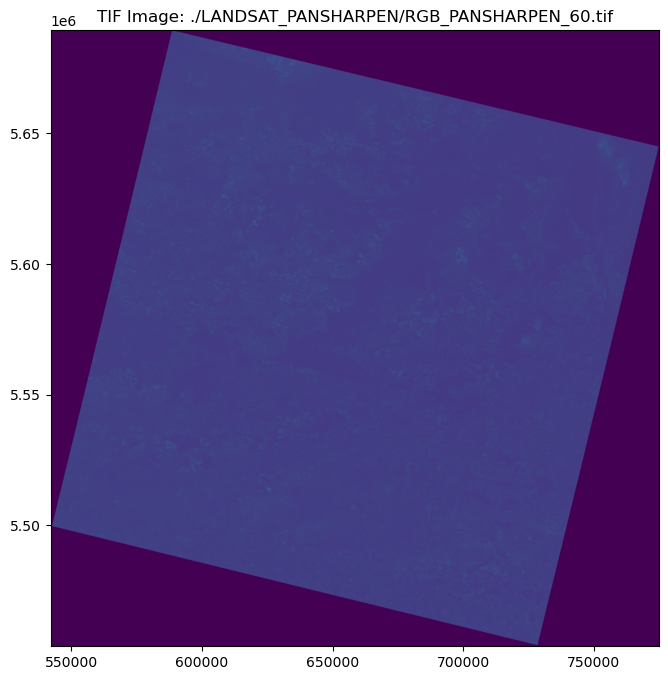

In [69]:
open_and_display_tif("./LANDSAT_PANSHARPEN/RGB_PANSHARPEN_60.tif")

- Після цього паншарпніть 60 метровий RGB за допомогою 30 м
панхроматичного каналу.

In [76]:
import subprocess

pansharpen_methods = ['average', 'nearest', 'bilinear', 'cubic', 'cubicspline', 'lanczos']

for method in pansharpen_methods:
    output_file = f'./LANDSAT_PANSHARPEN/PANSHARPEN_{method}.tif'
    gdal_pansharpen_cmd = [
        "python",  # додано
        "gdal_pansharpen.py", "-r", method,
        "./LANDSAT_PANSHARPEN/RGB_PANSHARPEN_30_B8.tif",
        "./LANDSAT_PANSHARPEN/RGB_PANSHARPEN_60.tif",
        output_file
    ]
    try:
        result = subprocess.run(gdal_pansharpen_cmd, capture_output=True, text=True, check=True)
        print(f"{method}: Успішно")
    except subprocess.CalledProcessError as e:
        print(f"Помилка при методі {method}:")
        print(e.stdout)
        print(e.stderr)


average: Успішно
nearest: Успішно
bilinear: Успішно
cubic: Успішно
cubicspline: Успішно
lanczos: Успішно


Displaying ./LANDSAT_PANSHARPEN/PANSHARPEN_average.tif


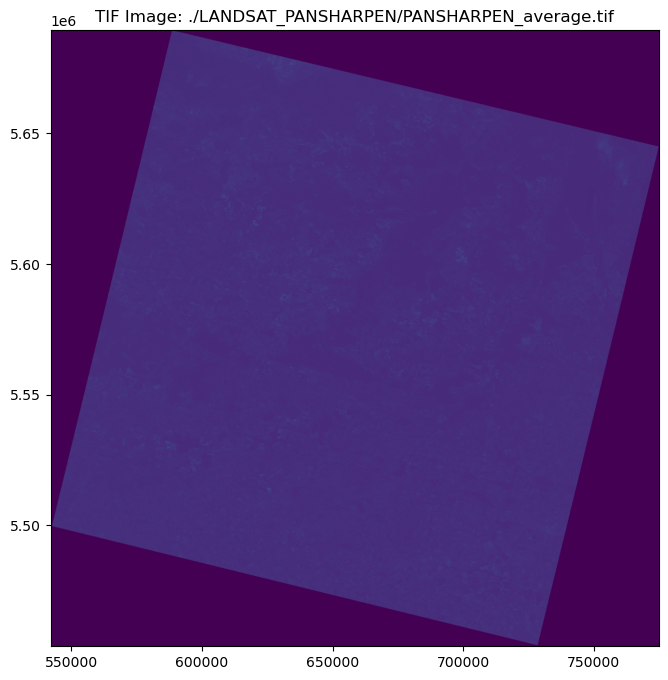

Displaying ./LANDSAT_PANSHARPEN/PANSHARPEN_nearest.tif


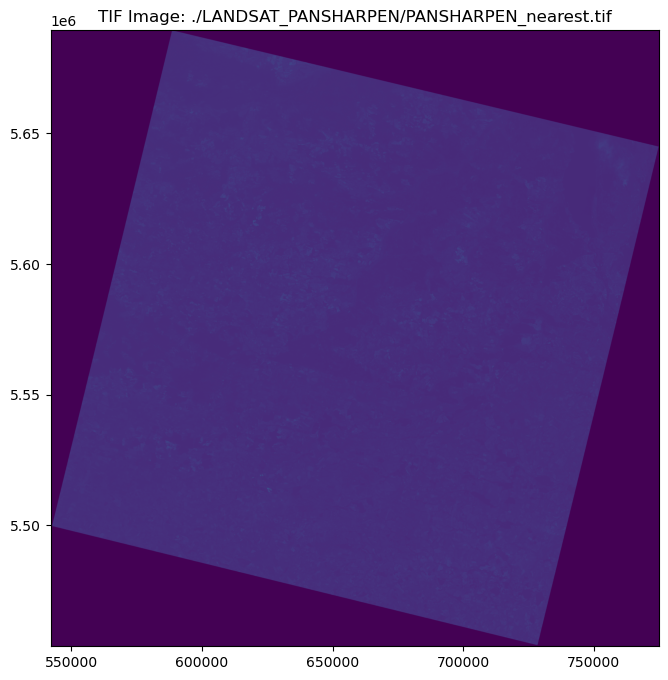

Displaying ./LANDSAT_PANSHARPEN/PANSHARPEN_bilinear.tif


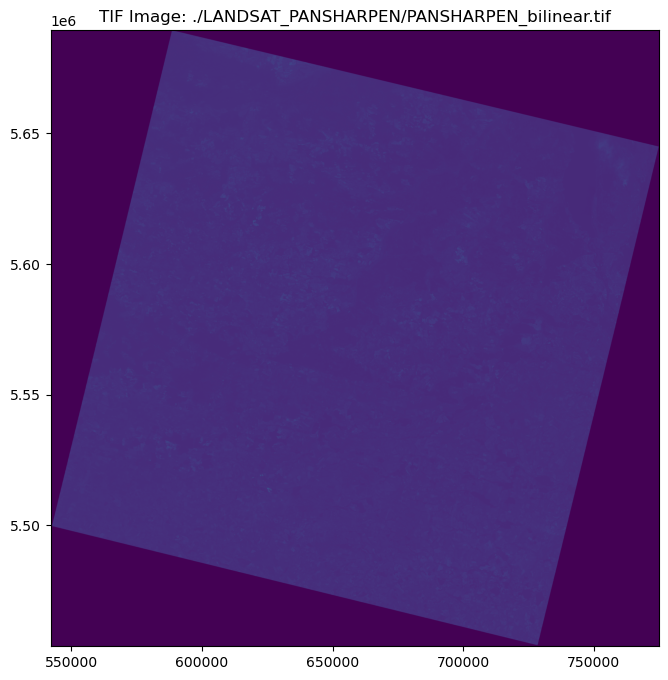

Displaying ./LANDSAT_PANSHARPEN/PANSHARPEN_cubic.tif


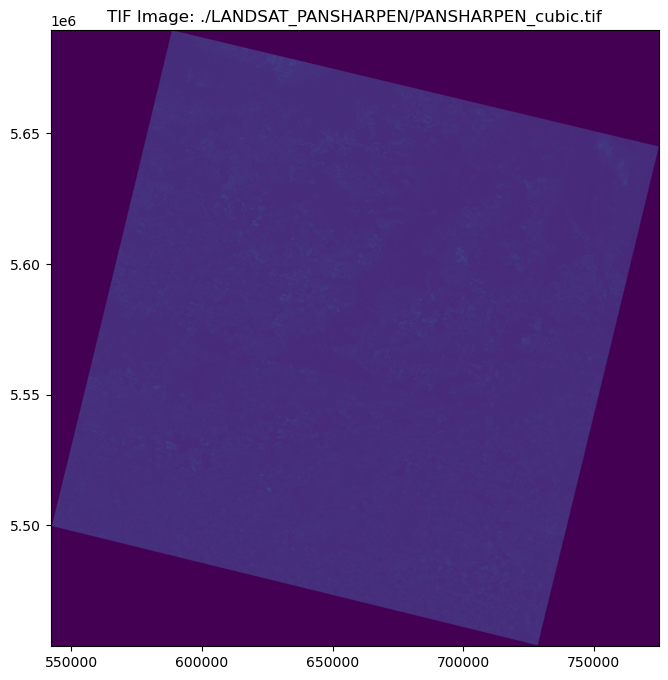

Displaying ./LANDSAT_PANSHARPEN/PANSHARPEN_cubicspline.tif


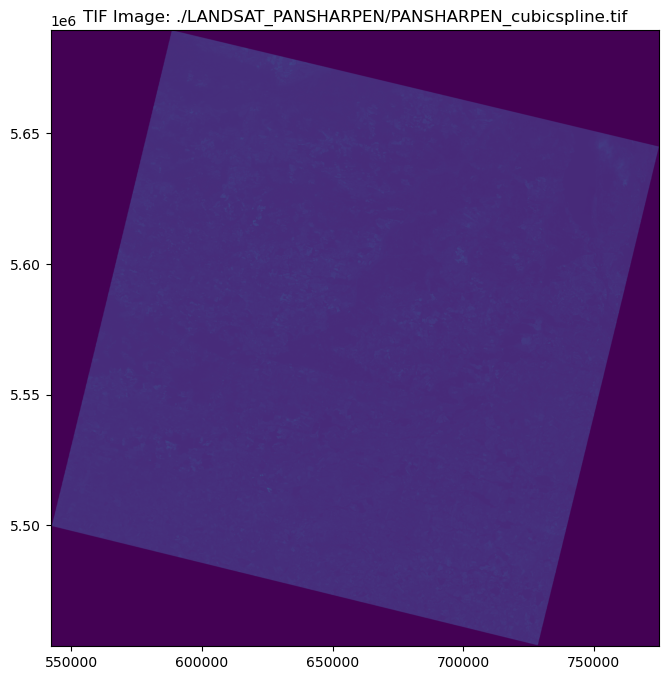

Displaying ./LANDSAT_PANSHARPEN/PANSHARPEN_lanczos.tif


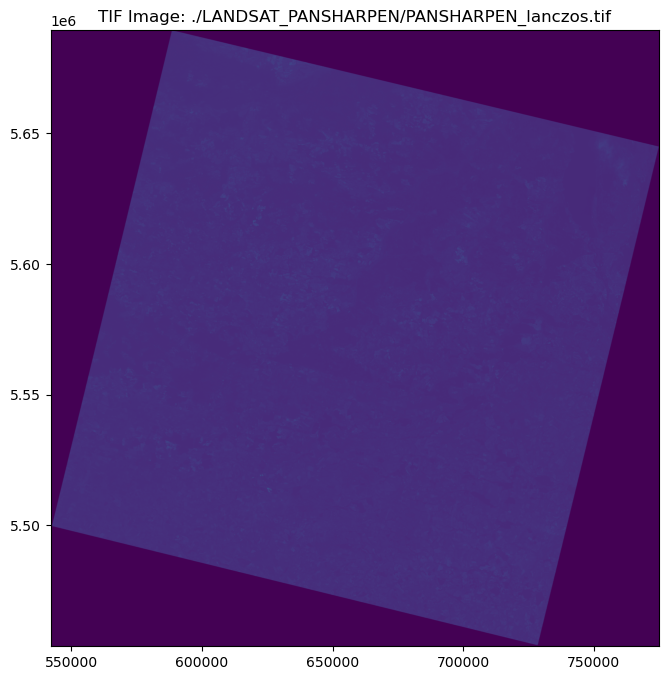

In [77]:
open_and_display_tif("./LANDSAT_PANSHARPEN/PANSHARPEN_average.tif")
open_and_display_tif("./LANDSAT_PANSHARPEN/PANSHARPEN_nearest.tif")
open_and_display_tif("./LANDSAT_PANSHARPEN/PANSHARPEN_bilinear.tif")
open_and_display_tif("./LANDSAT_PANSHARPEN/PANSHARPEN_cubic.tif")
open_and_display_tif("./LANDSAT_PANSHARPEN/PANSHARPEN_cubicspline.tif")
open_and_display_tif("./LANDSAT_PANSHARPEN/PANSHARPEN_lanczos.tif")

 Після цього ви отримуєте два 30 метрових RGB
зображення - перший оригінальний, другий паншарпнутий. Підрахуйте
метрики точності паншарпенінгу (це будь які вам відомі метрики які можна
використовувати для валідації регресії, наприклад r square). 

In [78]:
pansharpen_methods = {
   'average': rasterio.open('./LANDSAT_PANSHARPEN/PANSHARPEN_average.tif').read().flatten(),
   'nearest': rasterio.open('./LANDSAT_PANSHARPEN/PANSHARPEN_nearest.tif').read().flatten(),
   'bilinear': rasterio.open('./LANDSAT_PANSHARPEN/PANSHARPEN_bilinear.tif').read().flatten(),
   'cubic': rasterio.open('./LANDSAT_PANSHARPEN/PANSHARPEN_cubic.tif').read().flatten(),
   'cubicspline': rasterio.open('./LANDSAT_PANSHARPEN/PANSHARPEN_cubicspline.tif').read().flatten(),
   'lanczos': rasterio.open('./LANDSAT_PANSHARPEN/PANSHARPEN_lanczos.tif').read().flatten()
}

# Відкриття вихідного файлу для порівняння
reference = rasterio.open('./concat_LC08_25_RGB/concatenated_RGB.tif').read().flatten()

# Середньоквадратичні помилки (MSE) для кожного методу паншарпенінгу
similarity_scores = {}
for method, data in pansharpen_methods.items():
   try:
       r2_score = sklearn.metrics.r2_score(reference, data)
       similarity_scores[method] = r2_score
   except ValueError as e:
       print(f"Помилка під час обробки методу '{method}': {e}. Можливо, файли мають різні розміри або формати.")

# Виведення результатів
print("R2_SCORE для кожного методу паншарпенінгу:")
for method, score in similarity_scores.items():
   print(f"{method.capitalize():12}: {score:.4f}")



R2_SCORE для кожного методу паншарпенінгу:
Average     : 0.9949
Nearest     : 0.9944
Bilinear    : 0.9949
Cubic       : 0.9944
Cubicspline : 0.9928
Lanczos     : 0.9940
